<a href="https://colab.research.google.com/github/elmahmudi/OrganImageSegmentation/blob/main/COS6030_B_Coursework_Starter_Vision%2BPrompting_CLIP1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# COS6030-B Coursework Starter — Computer Vision **with Prompting** (Transformers/CLIP)
**Runs on Colab CPU** (small subsets).

**You will:**
- Zero-shot CLIP classification with prompts
- Prompt engineering & evaluation
- Few-shot linear probe (CPU-friendly)
- Text→Image retrieval with CLIP
- Directions to extend into coursework
- Add GitHub

> **Instructor notes:** Relates Mix+Squash & transformers to practical prompting. CPU-only by using frozen CLIP + linear probe.

In [ ]:
#@title Setup (CPU) — installs
!pip -q install transformers>=4.40 torchvision>=0.16 scikit-learn matplotlib pillow --progress-bar off

In [ ]:
#@title Imports & environment check (CPU)
import os, random, numpy as np, matplotlib.pyplot as plt, torch
from torchvision import datasets
from PIL import Image
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
device = torch.device("cpu"); print("Torch:", torch.__version__, "| Device:", device)

Torch: 2.9.0+cu126 | Device: cpu


## 1) Problem framing
Small CIFAR-10 subset → zero-shot CLIP with prompts → prompt engineering → few-shot linear probe → retrieval.

## 2) Data — CIFAR-10 (5 classes for speed)
Classes: `airplane, automobile, bird, cat, dog`.

In [ ]:
#@title Load subset
wanted_classes = ["airplane","automobile","bird","cat","dog"]
cifar10_labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
wanted_idx = [cifar10_labels.index(c) for c in wanted_classes]
train_all = datasets.CIFAR10("./data", train=True, download=True)
test_all  = datasets.CIFAR10("./data", train=False, download=True)

def filter_subset(dataset, wanted_idx, max_per_class=200):
    counts = {i:0 for i in wanted_idx}; images, labels = [], []
    for img, y in dataset:
        if y in wanted_idx and counts[y] < max_per_class:
            images.append(img); labels.append(wanted_idx.index(y)); counts[y]+=1
        if all(counts[i] >= max_per_class for i in wanted_idx): break
    return images, np.array(labels)

X_train_imgs, y_train = filter_subset(train_all, wanted_idx, 150)  # 750 imgs
X_test_imgs,  y_test  = filter_subset(test_all,  wanted_idx, 100)  # 500 imgs
print(f"Train {len(X_train_imgs)} | Test {len(X_test_imgs)} | Classes: {wanted_classes}")

100%|██████████| 170M/170M [00:06<00:00, 27.3MB/s]


Train 750 | Test 500 | Classes: ['airplane', 'automobile', 'bird', 'cat', 'dog']


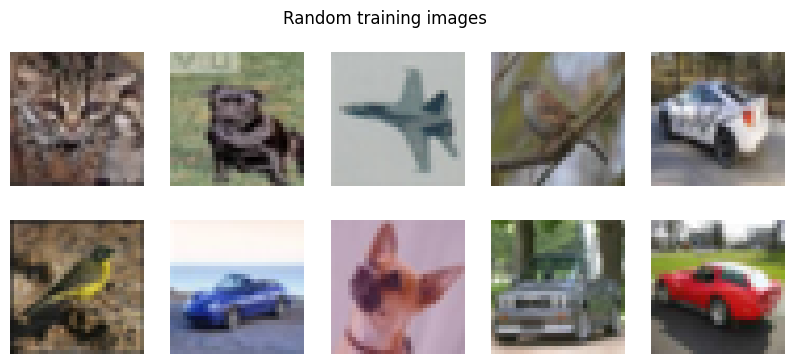

In [ ]:
#@title Visual check
rows, cols = 2, 5
import matplotlib.pyplot as plt, random
plt.figure(figsize=(10,4))
for i in range(rows*cols):
    idx = random.randrange(len(X_train_imgs))
    plt.subplot(rows, cols, i+1); plt.imshow(X_train_imgs[idx]); plt.axis('off')
plt.suptitle("Random training images"); plt.show()

## 3) Zero-shot CLIP (prompting)
Encode prompts for each class; choose the class with highest cosine similarity to the image.

In [ ]:
#@title Load CLIP (ViT-B/32)
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer
model_id = "openai/clip-vit-base-patch32"
clip_model = CLIPModel.from_pretrained(model_id); clip_processor = CLIPProcessor.from_pretrained(model_id)
tokenizer = AutoTokenizer.from_pretrained(model_id)
clip_model.to(device); clip_model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e-05,

In [ ]:
#@title Text embeddings from prompts
import torch
def build_text_matrix(labels, templates):
    text_embeds = []
    for label in labels:
        prompts = [t.format(label=label) for t in templates]
        inputs = clip_processor(text=prompts, padding=True, return_tensors="pt")
        with torch.no_grad():
            feats = clip_model.get_text_features(**{k:v.to(device) for k,v in inputs.items()})
        feats = feats / feats.norm(dim=-1, keepdim=True)
        mean_feat = feats.mean(dim=0); mean_feat = mean_feat / mean_feat.norm()
        text_embeds.append(mean_feat.cpu())
    return torch.stack(text_embeds, dim=0)

default_templates = ["a photo of a {label}"]
text_matrix = build_text_matrix(wanted_classes, default_templates)
text_matrix.shape

torch.Size([5, 512])

Zero-shot accuracy: 0.944


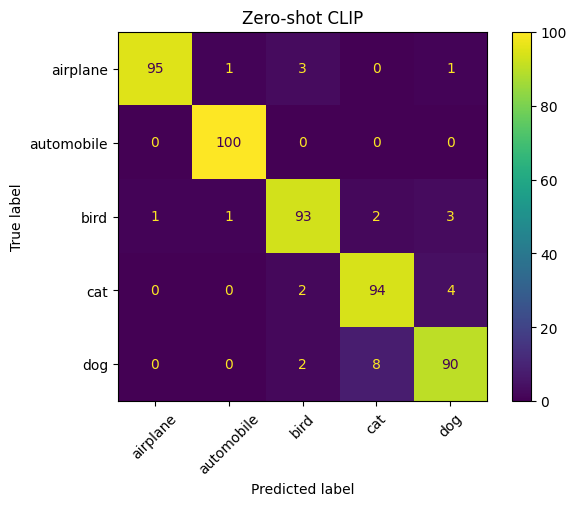

In [ ]:
#@title Evaluate zero-shot
from tqdm import tqdm
def image_features(images, batch_size=64):
    feats = []
    for i in range(0, len(images), batch_size):
        batch = images[i:i+batch_size]
        inputs = clip_processor(images=batch, return_tensors="pt")
        with torch.no_grad():
            img_feats = clip_model.get_image_features(**{k:v.to(device) for k,v in inputs.items()})
        img_feats = img_feats / img_feats.norm(dim=-1, keepdim=True)
        feats.append(img_feats.cpu())
    return torch.cat(feats, dim=0)

img_feats_test = image_features(X_test_imgs, 64)
logits = img_feats_test @ text_matrix.T
y_pred = logits.argmax(dim=1).numpy()
acc = accuracy_score(y_test, y_pred)
print(f"Zero-shot accuracy: {acc:.3f}")
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=wanted_classes).plot(values_format='d'); plt.xticks(rotation=45); plt.title("Zero-shot CLIP"); plt.show()

In [ ]:
#@title Prompt engineering: multi-template
templates = ["a photo of a {label}",
             "a blurry photo of a {label}",
             "a close-up photo of a {label}",
             "a low-resolution photo of a {label}",
             "a JPEG photo of a {label}"]
text_matrix = build_text_matrix(wanted_classes, templates)
logits = img_feats_test @ text_matrix.T
y_pred = logits.argmax(dim=1).numpy()
acc = accuracy_score(y_test, y_pred)
print(f"Zero-shot accuracy with {len(templates)} templates: {acc:.3f}")

Zero-shot accuracy with 5 templates: 0.952


In [ ]:
#@title Transformer view: tokenisation
prompt = "a close-up photo of a cat"
enc = tokenizer(prompt, return_tensors="pt")
tokens = tokenizer.convert_ids_to_tokens(enc["input_ids"][0])
print("Tokens:", tokens); print("IDs shape:", enc["input_ids"].shape)

Tokens: ['<|startoftext|>', 'a</w>', 'close</w>', '-</w>', 'up</w>', 'photo</w>', 'of</w>', 'a</w>', 'cat</w>', '<|endoftext|>']
IDs shape: torch.Size([1, 10])


## 4) Few-shot **linear probe**
Train a logistic regression on frozen CLIP features (CPU-friendly).

In [ ]:
#@title Feature extraction
img_feats_train = image_features(X_train_imgs, 64).numpy()
img_feats_test_np = img_feats_test.numpy()
print(img_feats_train.shape, img_feats_test_np.shape)

(750, 512) (500, 512)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Linear probe accuracy (80/class): 0.944


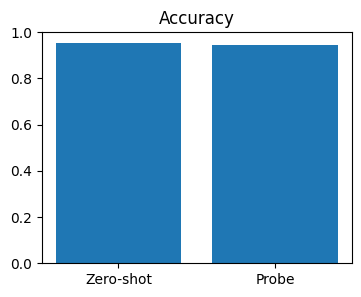

In [ ]:
#@title Train & compare
max_train_per_class = 80
counts = [0]*len(wanted_classes); Xtr, ytr = [], []
for i,(img,y) in enumerate(zip(X_train_imgs, y_train)):
    if counts[y] < max_train_per_class:
        Xtr.append(img_feats_train[i]); ytr.append(y); counts[y]+=1
    if all(c>=max_train_per_class for c in counts): break
Xtr = np.stack(Xtr); ytr = np.array(ytr)
clf = LogisticRegression(max_iter=2000, multi_class="multinomial"); clf.fit(Xtr, ytr)
y_pred_probe = clf.predict(img_feats_test_np)
acc_probe = accuracy_score(y_test, y_pred_probe)
print(f"Linear probe accuracy ({max_train_per_class}/class): {acc_probe:.3f}")
zs_acc = accuracy_score(y_test, (img_feats_test @ text_matrix.T).argmax(dim=1).numpy())
plt.figure(figsize=(4,3)); plt.bar([0,1],[zs_acc, acc_probe]); plt.xticks([0,1],["Zero-shot","Probe"]); plt.ylim(0,1); plt.title("Accuracy"); plt.show()

## 5) Text → Image retrieval
Search a small gallery by a text query using CLIP cosine similarity.

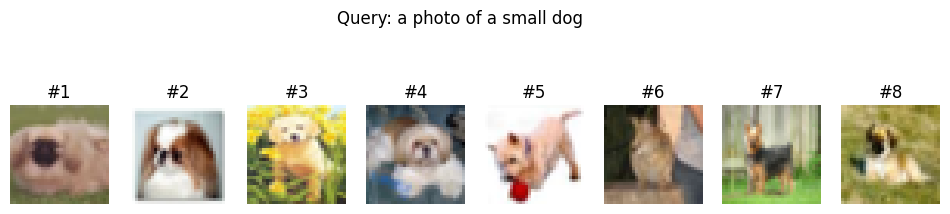

In [ ]:
#@title Retrieval demo
gallery_size = 120; K = 8; query = "a photo of a small dog"
gallery_imgs = X_test_imgs[:gallery_size]; gallery_feats = img_feats_test[:gallery_size]
inputs = clip_processor(text=[query], return_tensors="pt")
with torch.no_grad():
    q = clip_model.get_text_features(**{k:v for k,v in inputs.items()})
q = q / q.norm(dim=-1, keepdim=True)
sims = (gallery_feats @ q.cpu().T).squeeze(1).numpy()
topk_idx = np.argsort(-sims)[:K]
plt.figure(figsize=(12,3))
for i, idx in enumerate(topk_idx):
    plt.subplot(1,K,i+1); plt.imshow(gallery_imgs[idx]); plt.axis('off'); plt.title(f"#{i+1}")
plt.suptitle(f"Query: {query}"); plt.show()

## 6) Extend into your coursework
**Swap dataset**, design **prompt families**, run **ablation** on shots, add **calibration**, discuss **risks/ethics**, and propose an **ops plan** (cost, deployment, monitoring). Keep everything reproducible.